# Deep Learning Assignment 2 - Part A
## Declan Stockdale

## Transfer Learning

In [146]:
#import various functions

# tensorflow imports
import tensorflow as tf
from tensorflow.keras.applications import inception_resnet_v2,InceptionResNetV2, mobilenet_v3,MobileNetV3Small, nasnet, NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense

# others
import os.path
import pathlib
import random

# sklearn and plotting
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,f1_score,precision_score, recall_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# image manipulation 
import visualkeras
import cv2 as cv
from PIL import ImageFont

In [147]:
#!pip install nbconvert 

In [2]:
# check gpu to make sure its connected to local GPU

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

### Function for transforming classification report into a dataframe

In [3]:
# create function for generating classification report from sklearn
# sklearn format is a string, I want a dataframe to sort the various metrics by
# splits string output gets relevant split number
# values are then stored in a dictionary and converted to a df as its cheaper than appending to a df

def classification_report_df(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[len(row_data)-5]
        row['precision'] = float(row_data[len(row_data)-4])
        row['recall'] = float(row_data[len(row_data)-3])
        row['f1_score'] = float(row_data[len(row_data)-2])
        row['support'] = float(row_data[len(row_data)-1])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.columns = ["label", "precision", "recall", "f1_score","support"]
    return dataframe

### Function to plot model history

In [126]:
# plot results given a model and a title
# used to go through history of model and plot various metrics

def plot_results(model, title):
    history = model
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title + 'model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.locator_params(axis="both", integer=True, tight=True)
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title + 'model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.locator_params(axis="both", integer=True, tight=True)
    plt.show()

In [127]:
# set path to locally downloaded folder

folder_path=("C:/Users/Declan/Desktop/MDSI/2022/DL - 94691/Assignment2/food-101/")

## Get training files

In [6]:
# training files are in a txt file in /food-101/meta/train.txt

train_file = open(folder_path+'/food-101/meta/train.txt','r')

# read contents of txt file
train_contents = train_file.read()
train_contents = list(train_contents.split('\n'))

# set empty lists 
training_label = []
training_id = []

for value in train_contents[:-2]:
  label,img_id = value.split('/')
  training_label.append(label)
  training_id.append(folder_path+'/food-101/images/'+label+'/'+img_id+'.jpg')

# close txt file
train_file.close()

In [7]:
# concateate into one dataframe with filepath and label

# series of filepaths
training_filepaths = pd.Series(training_id, name = 'filepath').astype(str)

#series of labels
training_label = pd.Series(training_label , name = 'label')

# concat the two series
train_df = pd.concat([training_filepaths, training_label], axis = 1)

### Get testing files

In [8]:
# same process as with training files

# open test txt
test_file = open(folder_path+'/food-101/meta/test.txt', "r")
test_contents = test_file.read()
test_contents = list(test_contents.split('\n'))

# empty list
test_label = []
test_id = []

# split by /, last two elements are label and image id respectively
# append output to the lists

for value in test_contents[:-2]:
  label,img_id = value.split('/')
  test_label.append(label)
  test_id.append(folder_path+'/food-101/images/'+label+'/'+img_id+'.jpg')

# close the file
test_file.close()

In [9]:
# concat into one dataframe with filepath and label using pandas series
test_filepaths = pd.Series(test_id, name = 'filepath').astype(str)
test_label = pd.Series(test_label , name = 'label')
test_df = pd.concat([test_filepaths, test_label], axis = 1)

# Train test shuffle

In [10]:
# shuffle the data
# I know that the training data apepars by class e.g. apple_pie will be the first however many images then the next categry will appear

# drop the index
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
# how many images in each set
print('number of train images = ', len(train_df))
print('number of test images  = ', len(test_df))

number of train images =  75749
number of test images  =  25249


## Display first 10 images of unique classes 

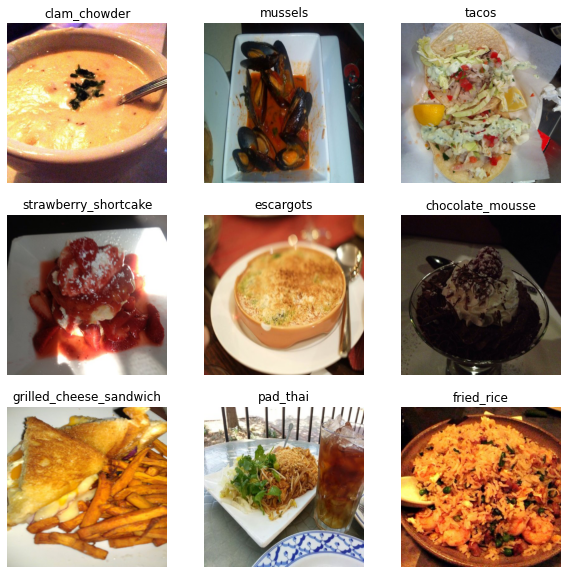

In [12]:
# create figure  with 3x3 dimensions
fig=plt.figure(figsize=(10,10))
columns = 3
rows = 3

# Get first 9 images and display them along with their label
# images are resized to better display them
for i in range(9):
    fig.add_subplot(rows, columns, i+1)
    image = plt.imread(train_df.iloc[i][0])
    image = cv.resize(image, (400, 400))  
    plt.imshow(image) # black and white
    plt.axis('off') # turn off axis
    plt.title(train_df.iloc[i][1])  # label just needs to be i as thats how the list was created
plt.show()

## Display steak images to demonstrate differences in pictures

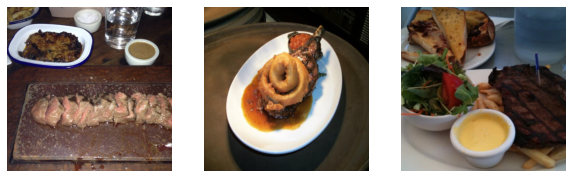

In [165]:
# noticed that steaks look widely different depending on serving style and accompanying side dishes
# plot random exmaples 

# create figure
fig=plt.figure(figsize=(10,10))
columns = 3
rows = 1

# set dir to steak #523535, 217250
steak_dir = folder_path+'/food-101/images/steak/'
# get list 
steak_dir_list = os.listdir(steak_dir)

# Get 4 random steak images
for i in range(3):
    fig.add_subplot(rows, columns, i+1)
    image = plt.imread(folder_path+'/food-101/images/steak/'+random.choice(steak_dir_list))
    image = cv.resize(image, (400, 400))  
    plt.imshow(image) 
    plt.axis('off') # turn off axis
plt.show()

## Set top layer used for all 3 models

In [13]:
# top layer composed of 2 x 256 densely connected models with Relu and a 101 densel connected layer with softmax for prediction

top_layer = tf.keras.Sequential([    
    Dense(256, activation='relu'), # first fully connected layer
    Dense(256, activation='relu'), # second fully connected layer
    Dense(101, activation='softmax') # final output for 101 classes
])

In [105]:
top_layer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               256256    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 101)               25957     
                                                                 
Total params: 348,005
Trainable params: 348,005
Non-trainable params: 0
_________________________________________________________________


# Generators for models

## Inception Resnet V2

In [14]:
# generate train data with validation splot using inception resnet preprocessing
inception_train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input,
    validation_split = 0.2
)

# generate test data with validation splot using inception resnet preprocessing
inception_test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input
)

## Load data use dataframe created earlier

In [15]:
# load train set into train generator
# Batch size of 32, keep the colour channels
# shiffle once more
# use categorical class
# need to specify subset as we earlie specified a train and a validation set

inception_train = inception_train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)

# load train set into train generator
# Batch size of 32, keep the colour channels
# shiffle once more
# use categorical class
# need to specify subset as we earlier specified a train and a validation set
inception_val = inception_train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

# load test set into test generator
# Batch size of 32, keep the colour channels
# shuffle once more
# use categorical class

inception_test = inception_test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
)

Found 60600 validated image filenames belonging to 101 classes.
Found 15149 validated image filenames belonging to 101 classes.
Found 25249 validated image filenames belonging to 101 classes.


## Inception modelling

In [16]:
# import pretrained model
# set input shape according to documentation
# use max pooling
# dont inmport top layer
# import wih preloaded ImageNet weights 
inception_pretrained = InceptionResNetV2(
    input_shape = (299, 299, 3),
    include_top = 'False',
    weights = 'imagenet',
    pooling = 'max'
)

# set all layers to not be trainable
for layer in inception_pretrained.layers:
  layer.trainable = False

In [98]:
#inception_pretrained.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [97]:
# look at visualisation of model ,its way to deep to use in the report

visualkeras.layered_view(inception_pretrained, legend=True) # without custom font

font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(inception_pretrained, legend=True, font=font) # selected font

### Sequential model of original inception resnet v2 and the custom top layer

In [17]:
# Stack original model and custom model

tuned_model_inception = tf.keras.Sequential([
    inception_pretrained,
    top_layer 
])

In [18]:
# show summary
tuned_model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1000)             55873736  
 onal)                                                           
                                                                 
 sequential (Sequential)     (None, 101)               348005    
                                                                 
Total params: 56,221,741
Trainable params: 348,005
Non-trainable params: 55,873,736
_________________________________________________________________


## Training

In [19]:
# compile the model using the adam optimiser default of 0.001 according to documentation
# metric is categorical_crossentropy. This is becuase the generators output is a vector rather than integer representation in which case sparse would be the better choice

tuned_model_inception.compile(
    optimizer = 'adam', # 0.001 default
    loss = 'categorical_crossentropy', # vector due to imagedatagenertor
    metrics = 'accuracy'
)

# fit the modelwih 20 epochs and the early stopping callback 
tuned_model_inception_history = tuned_model_inception.fit(
    inception_train,
    validation_data = inception_val,
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(
                                                  monitor = 'val_loss',
                                                  patience = 5,
                                                  restore_best_weights = True)
    ]
)

Epoch 1/20
1894/1894 [==============================] - 328s 168ms/step - loss: 3.5494 - accuracy: 0.1655 - val_loss: 3.3748 - val_accuracy: 0.1932
Epoch 2/20
1894/1894 [==============================] - 316s 167ms/step - loss: 3.2986 - accuracy: 0.2009 - val_loss: 3.2805 - val_accuracy: 0.2024
Epoch 3/20
1894/1894 [==============================] - 320s 169ms/step - loss: 3.1865 - accuracy: 0.2186 - val_loss: 3.1981 - val_accuracy: 0.2222
Epoch 4/20
1894/1894 [==============================] - 320s 169ms/step - loss: 3.0952 - accuracy: 0.2368 - val_loss: 3.1369 - val_accuracy: 0.2326
Epoch 5/20
1894/1894 [==============================] - 318s 168ms/step - loss: 3.0212 - accuracy: 0.2502 - val_loss: 3.1054 - val_accuracy: 0.2423
Epoch 6/20
1894/1894 [==============================] - 315s 166ms/step - loss: 2.9603 - accuracy: 0.2612 - val_loss: 3.0628 - val_accuracy: 0.2530
Epoch 7/20
1894/1894 [==============================] - 316s 167ms/step - loss: 2.9087 - accuracy: 0.2729 - val_

In [20]:
#using model.save_weights() to save the weights of the model in HDF5 format
tuned_model_inception.save_weights("C:/Users/Declan/Desktop/MDSI/2022/DL - 94691/Assignment2/tuned_model_inception_15_epochs_weights.h5")

## Inception Results


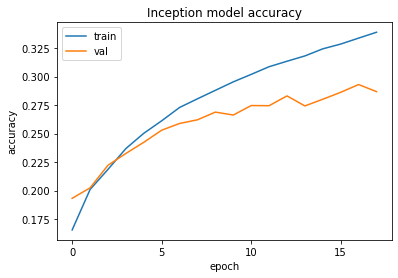

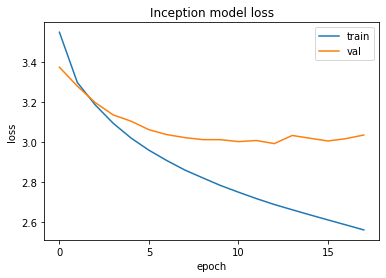

In [129]:
# plot results using earlier function
plot_results(tuned_model_inception_history, 'Inception ')

### Accuracy

In [21]:
# Look at accuracy
inception_results = tuned_model_inception.evaluate(inception_test)
print('Test set accuracy inception {:.2f}%'.format(inception_results[1]*100))  

790/790 [==============================] - 106s 134ms/step - loss: 2.7901 - accuracy: 0.3098
Test set accuracy inception 30.98%


### Get predictions

In [22]:
# Predict using argmax to get actual numerical representation of label
inception_predictions = np.argmax(tuned_model_inception.predict(inception_test), axis = 1) 

### Create confusion matrix

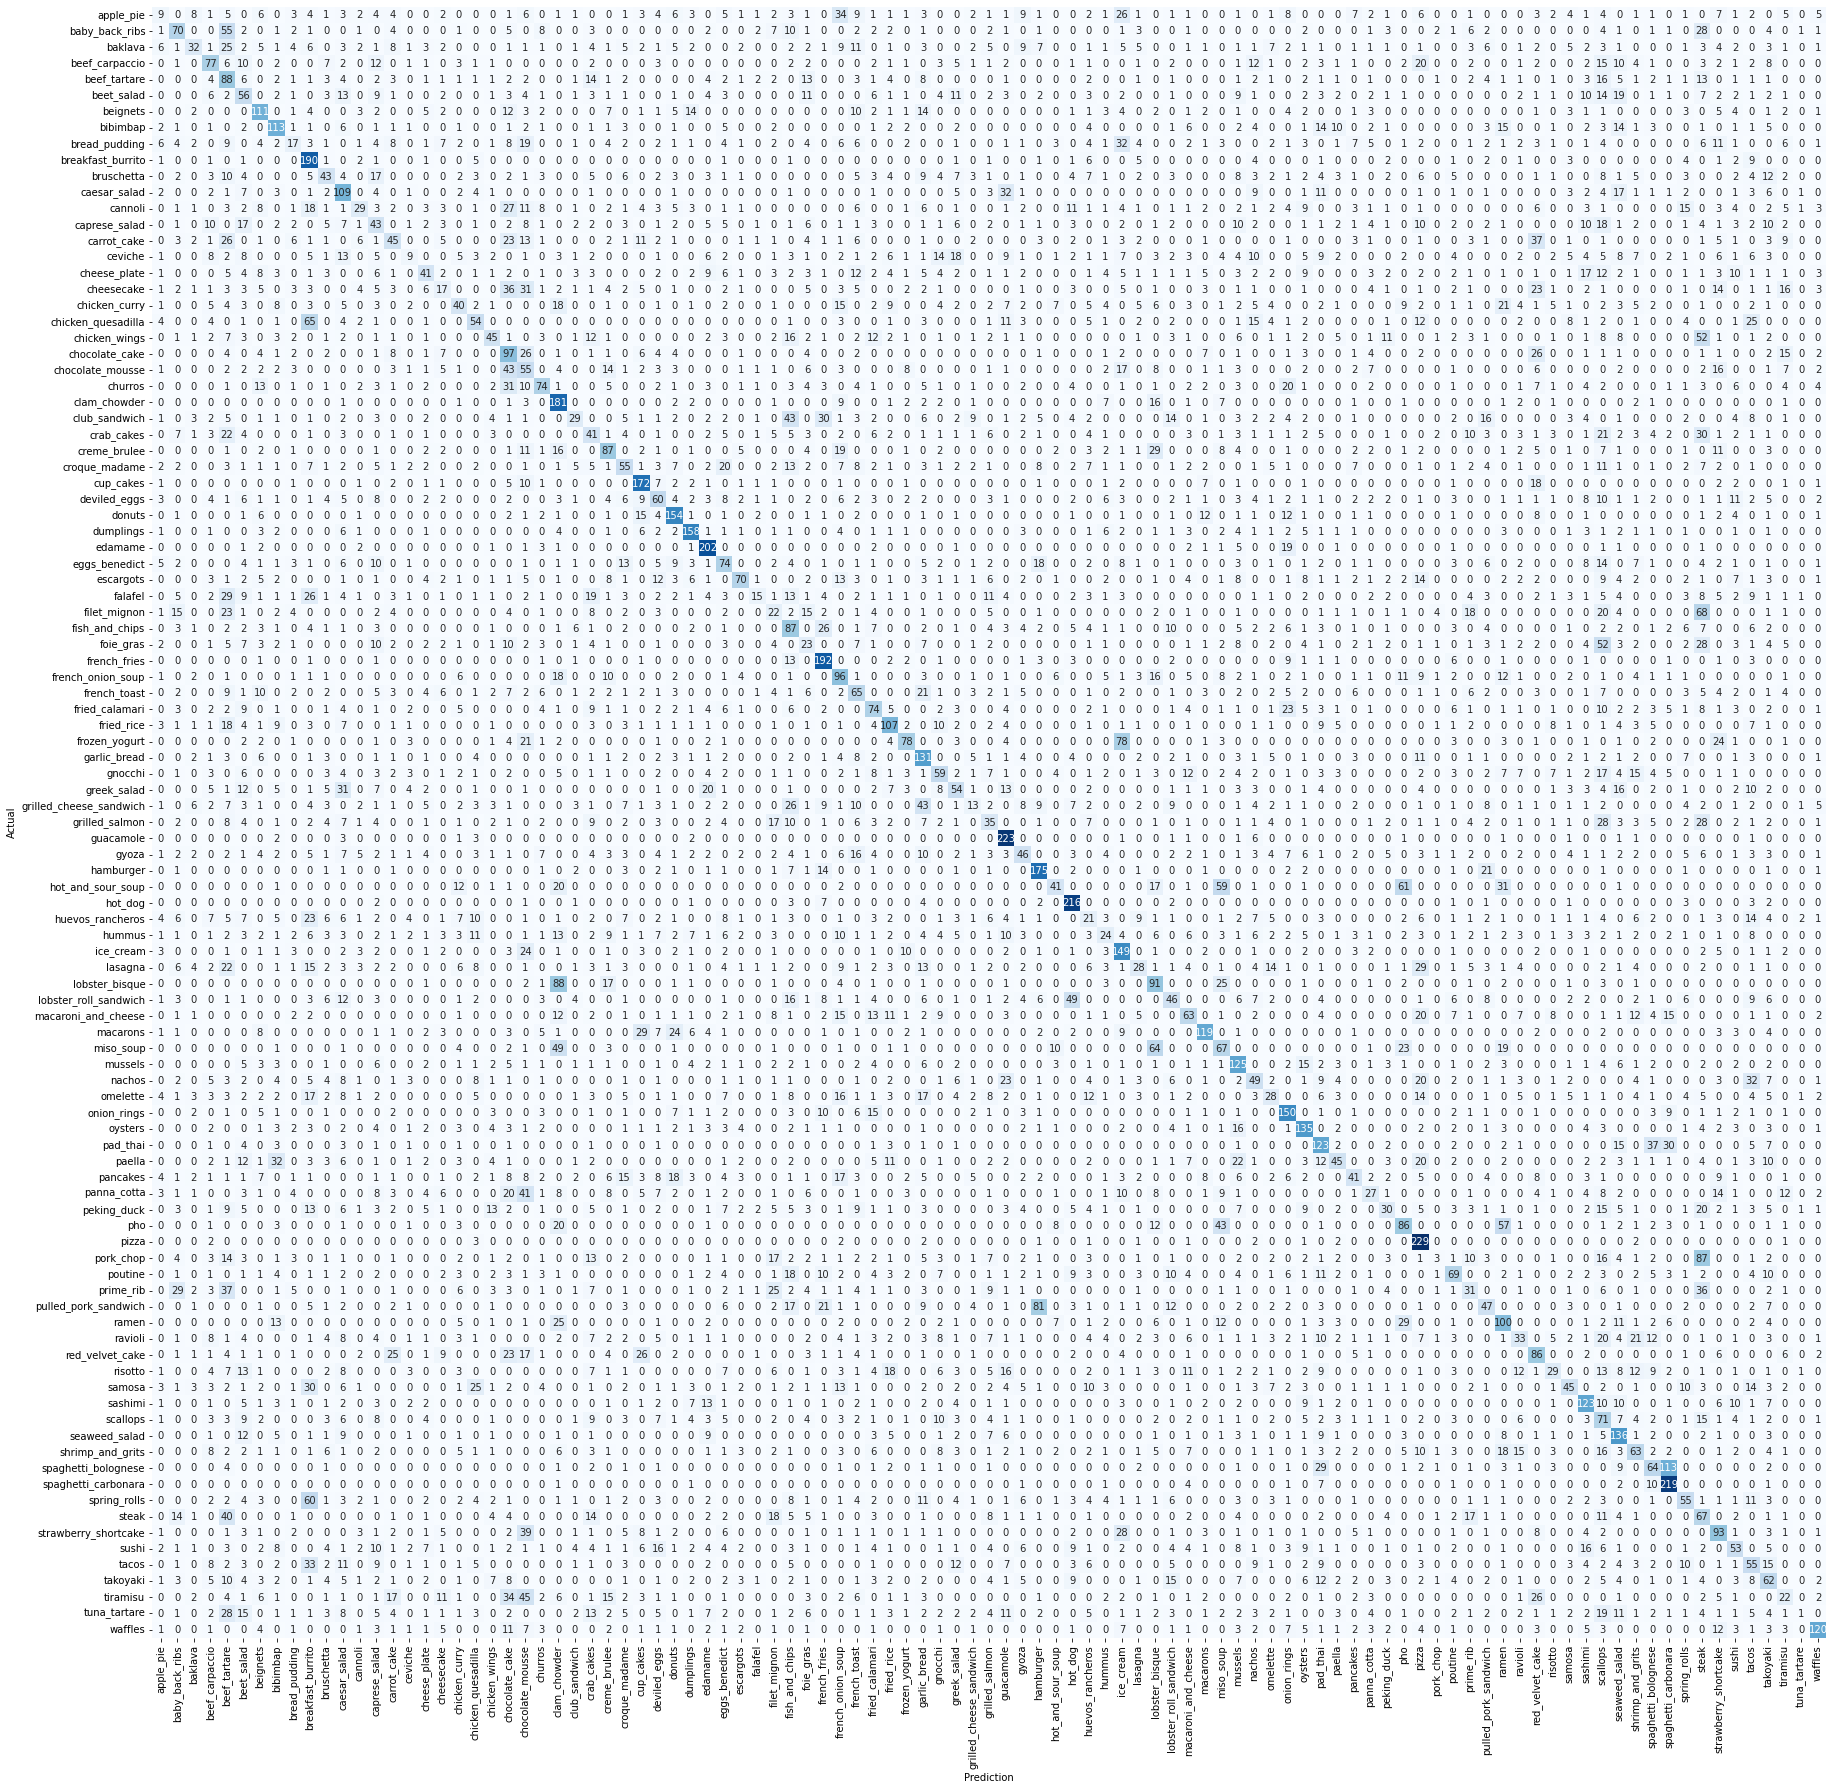

In [24]:
# create confusion matrix - will be too large to use in report
inception_conf_matrix = confusion_matrix(inception_test.labels,inception_predictions)

# create heatmap using seaborn blue colour scheme
# Label numeric represntation swapped for class indices which are human readable

plt.figure(figsize = (30,30))
sns.heatmap(inception_conf_matrix, vmin=0, annot = True, fmt = 'g', cmap = 'Blues', cbar = False)
plt.xticks(ticks = np.arange(101)+0.5, labels=inception_test.class_indices, rotation = 90)
plt.yticks(ticks = np.arange(101)+0.5, labels=inception_test.class_indices, rotation = 0)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

### Classification report - additional statistics

In [25]:
# Generate classificaiton report
inception_report = classification_report(inception_test.labels, inception_predictions, target_names=inception_test.class_indices)


In [26]:
# use funciton to convert report to df
inception_report_df = classification_report_df(inception_report)
inception_report_df

label  precision  recall  f1_score  support
0            apple_pie       0.10    0.04      0.05    250.0
1       baby_back_ribs       0.32    0.28      0.30    250.0
2              baklava       0.35    0.13      0.19    250.0
3       beef_carpaccio       0.32    0.31      0.31    250.0
4         beef_tartare       0.14    0.35      0.20    250.0
..                 ...        ...     ...       ...      ...
96               tacos       0.18    0.22      0.20    250.0
97            takoyaki       0.20    0.25      0.22    250.0
98            tiramisu       0.15    0.09      0.11    250.0
99        tuna_tartare       0.09    0.00      0.01    250.0
100            waffles       0.66    0.48      0.56    249.0

[101 rows x 5 columns]

In [27]:
# get top 10 by F1 score
inception_best_f1 = inception_report_df.sort_values(['f1_score'],ascending = False).reset_index(drop=True).head(10)

In [28]:
# get bottom 10 by F1 score
inception_worst_f1 = inception_report_df.sort_values(['f1_score'],ascending = True).reset_index(drop=True).head(10)

## -	mobilenet_v3

In [29]:
# set train test generators using mobilenet_v3 preprocessing and get validation split 
mobilenet_train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split = 0.2
)

mobilenet_test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input
)

## Load data use dataframe created earlier

In [30]:
# Put the training and test dfs through the generators 
# Training and valdiation sets are shuffled
# class mode is categorical
# batch size is set to 32


# need to specify training subset due to earlier validation split
mobilenet_train = mobilenet_train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)

# also get a validation split
mobilenet_val = mobilenet_train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

# put test df through generator
mobilenet_test = mobilenet_test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
)

Found 60600 validated image filenames belonging to 101 classes.
Found 15149 validated image filenames belonging to 101 classes.
Found 25249 validated image filenames belonging to 101 classes.


### Import model

In [31]:
# import pretrained model
# set input shape according to documentation
# use max pooling
# dont inmport top layer
# import wih preloaded ImageNet weights 

mobilenet_pretrained = MobileNetV3Small(
    input_shape = (224, 224, 3),
    include_top = 'False',
    weights = 'imagenet',
    pooling = 'max'
)

# set model to not be trainable
for layer in mobilenet_pretrained.layers:
  layer.trainable = False

In [32]:
# stack original model with top layer

tuned_model_mobilenet = tf.keras.Sequential([
    mobilenet_pretrained,
    top_layer 
])

In [107]:
# Look at summaru
tuned_model_mobilenet.summary()

### Train model

In [33]:
# compile model with most relevant loss metric using defualt adam values

tuned_model_mobilenet.compile(
    optimizer = 'adam', # 0.001 default
    loss = 'categorical_crossentropy', # vector due to imagedatagenertor
    metrics = 'accuracy'
)

# fit model using trainin data and callbacks 
tuned_model_mobilenet_history = tuned_model_mobilenet.fit(
    mobilenet_train,
    validation_data = mobilenet_val,
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(
                                                  monitor = 'val_loss',
                                                  patience = 5,
                                                  restore_best_weights = True)
    ]
)

Epoch 1/20
1894/1894 [==============================] - 260s 136ms/step - loss: 2.7269 - accuracy: 0.3191 - val_loss: 2.5579 - val_accuracy: 0.3541
Epoch 2/20
1894/1894 [==============================] - 258s 136ms/step - loss: 2.5387 - accuracy: 0.3535 - val_loss: 2.4881 - val_accuracy: 0.3730
Epoch 3/20
1894/1894 [==============================] - 258s 136ms/step - loss: 2.4460 - accuracy: 0.3761 - val_loss: 2.4195 - val_accuracy: 0.3890
Epoch 4/20
1894/1894 [==============================] - 255s 135ms/step - loss: 2.3651 - accuracy: 0.3898 - val_loss: 2.4057 - val_accuracy: 0.3907
Epoch 5/20
1894/1894 [==============================] - 248s 131ms/step - loss: 2.3032 - accuracy: 0.4036 - val_loss: 2.3594 - val_accuracy: 0.4028
Epoch 6/20
1894/1894 [==============================] - 247s 130ms/step - loss: 2.2556 - accuracy: 0.4140 - val_loss: 2.3361 - val_accuracy: 0.4113
Epoch 7/20
1894/1894 [==============================] - 248s 131ms/step - loss: 2.2066 - accuracy: 0.4246 - val_

In [34]:
#using model.save_weights() to save the weights of the model in HDF5 format
tuned_model_mobilenet.save_weights("C:/Users/Declan/Desktop/MDSI/2022/DL - 94691/Assignment2/tuned_model_mobilenet_15_epochs_weights.h5")

### MobileNet v3 results

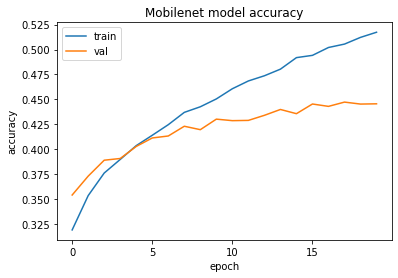

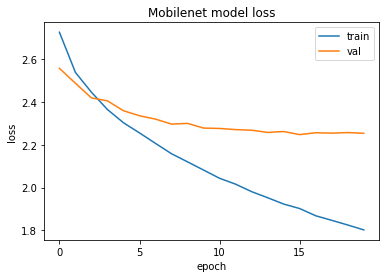

In [130]:
# show plots
plot_results(tuned_model_mobilenet_history, 'Mobilenet ')

### Accuracy

In [35]:
# get accuracy

mobilenet_results = tuned_model_mobilenet.evaluate(mobilenet_test)
print('Test set accuracy {:.2f}%'.format(mobilenet_results[1]*100))  

790/790 [==============================] - 84s 106ms/step - loss: 1.9900 - accuracy: 0.4860
Test set accuracy 48.60%


### Make predictions

In [36]:
mobilenet_predictions = np.argmax(tuned_model_mobilenet.predict(mobilenet_test), axis = 1) 

### Confusion matrix

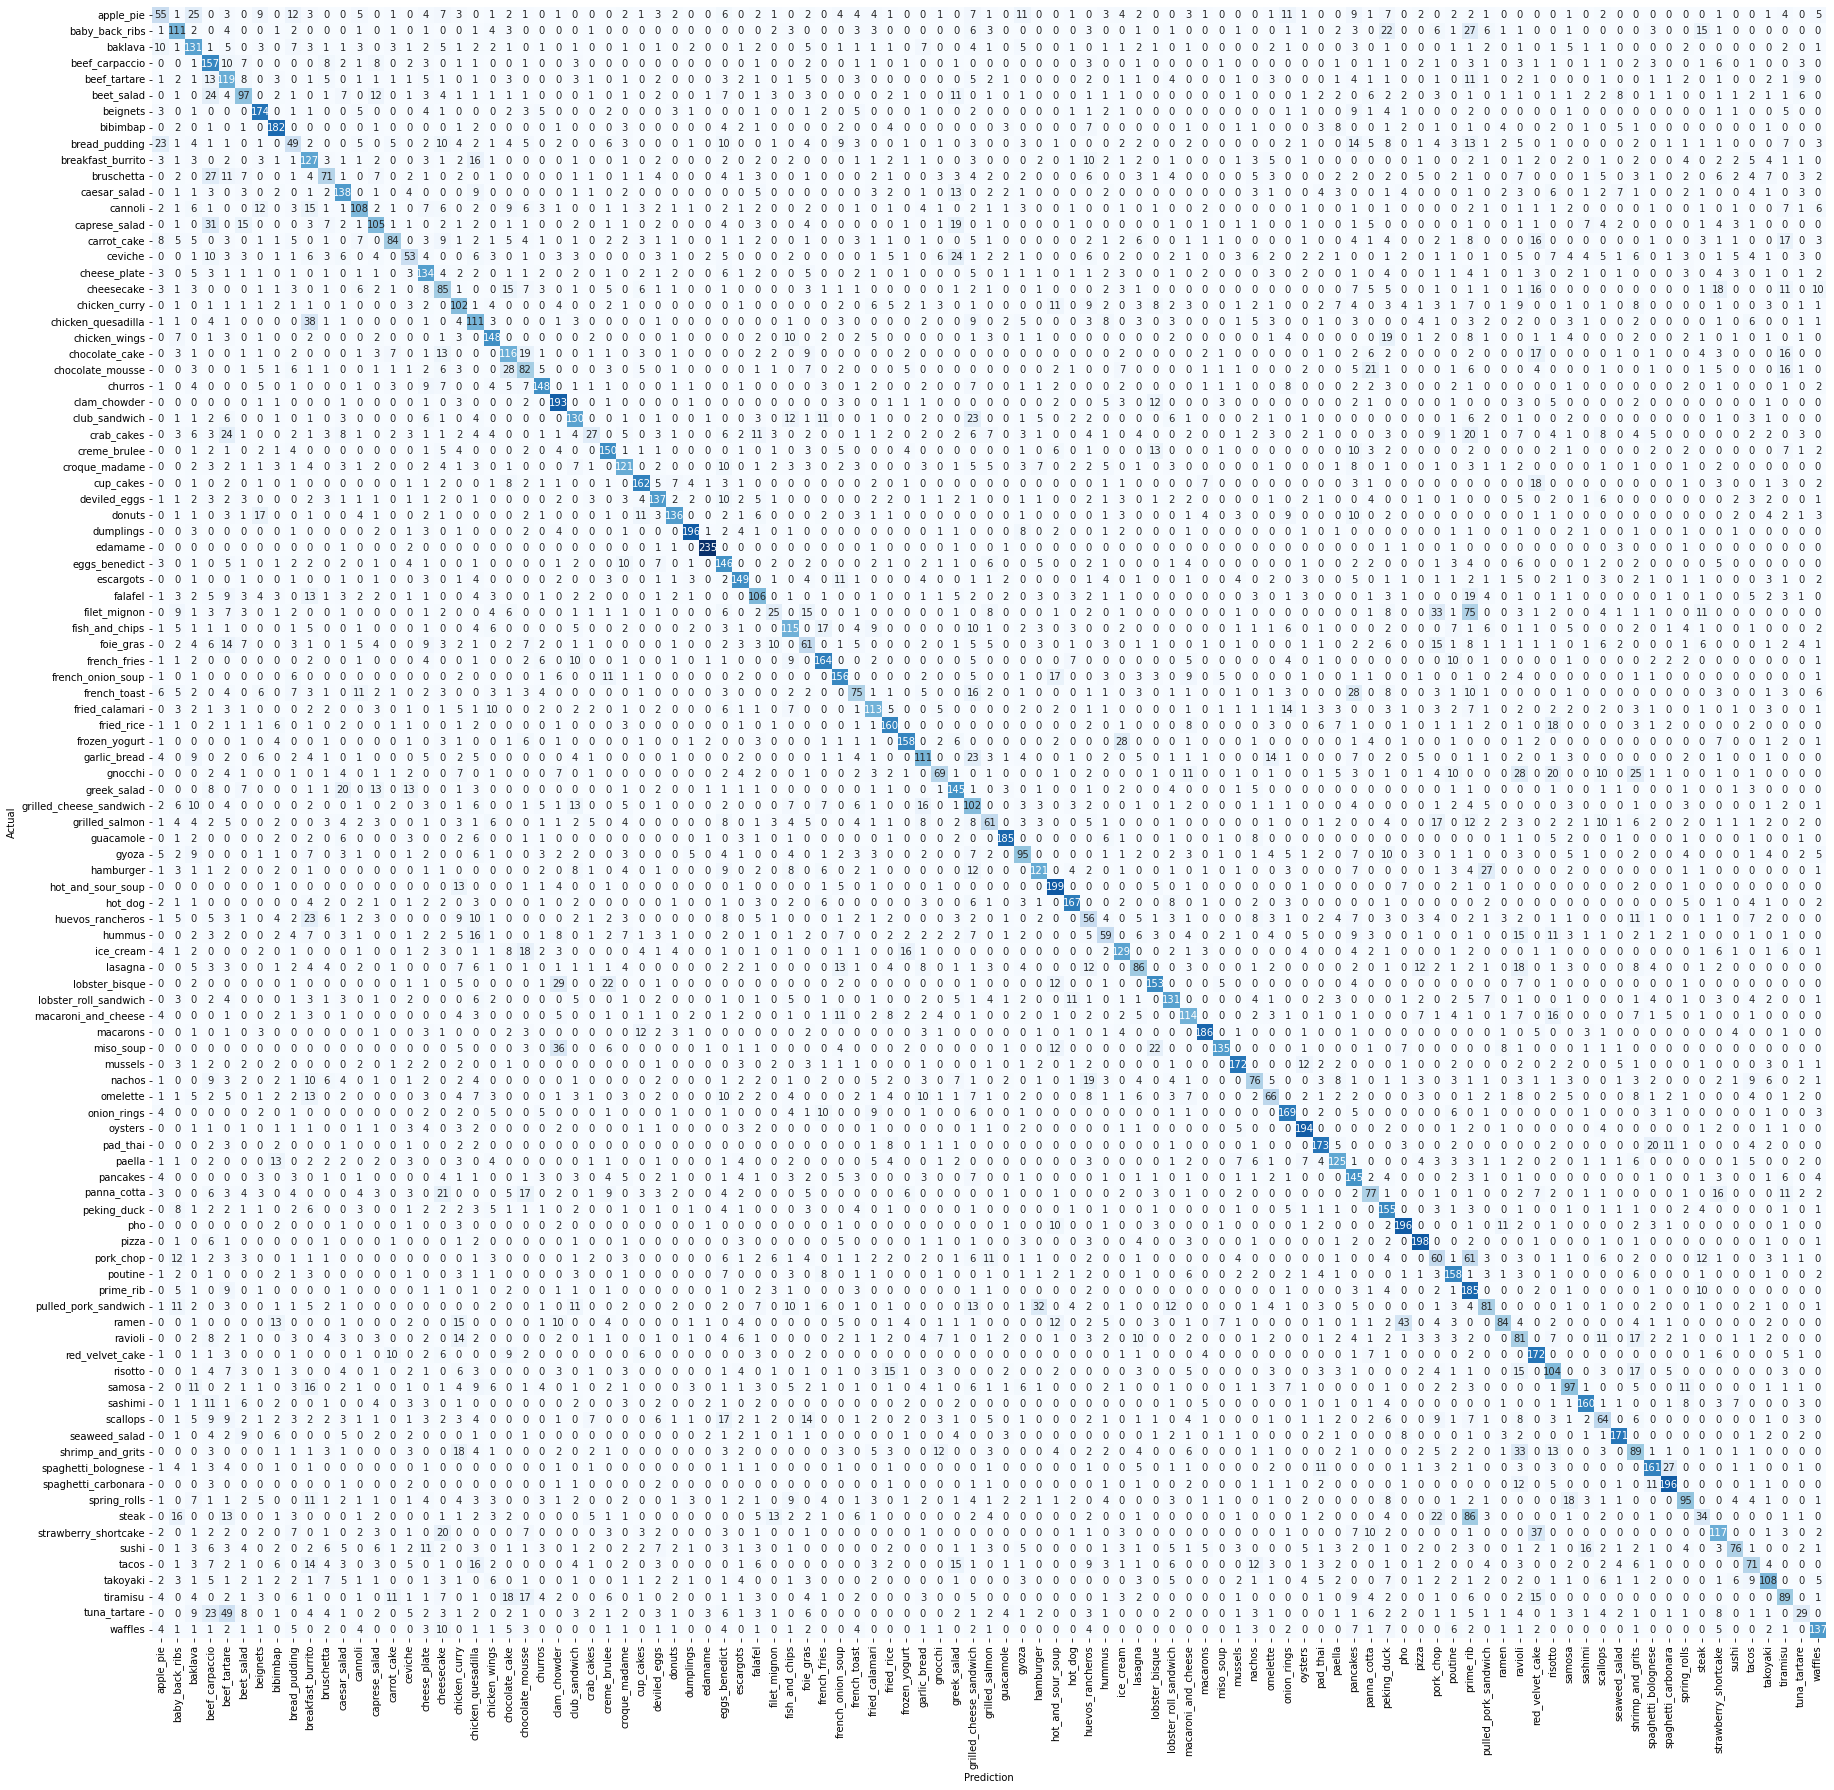

In [37]:
# create confusion matrix
mobilenet_conf_matrix = confusion_matrix(mobilenet_test.labels,mobilenet_predictions)

# create heatmap

plt.figure(figsize = (30,30))
sns.heatmap(mobilenet_conf_matrix, vmin=0, annot = True, fmt = 'g', cmap = 'Blues', cbar = False)
plt.xticks(ticks = np.arange(101)+0.5, labels=mobilenet_test.class_indices, rotation = 90)
plt.yticks(ticks = np.arange(101)+0.5, labels=mobilenet_test.class_indices, rotation = 0)
plt.xlabel('Prediction')
plt.ylabel('Actual')

plt.show()

### Classification report - additional statistics

In [38]:
# Generate classificaiton report
mobilenet_report = classification_report(mobilenet_test.labels, mobilenet_predictions, target_names=mobilenet_test.class_indices)


In [39]:
# Parse through functio to convert to df
mobilenet_report_df = classification_report_df(mobilenet_report)

In [40]:
# get top 10 by F1 score
mobilenet_best_f1=mobilenet_report_df.sort_values(['f1_score'],ascending = False).reset_index(drop=True).head(10)

In [41]:
# get bottom 10 by F1 score
mobilenet_worst_f1 = mobilenet_report_df.sort_values(['f1_score'],ascending = True).reset_index(drop=True).head(10)

## Nasnet

### Generators

In [42]:
# implement generators and a train val split
nasnet_train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.nasnet.preprocess_input,
    validation_split = 0.2
)

# genearte test generatr
nasnet_test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.nasnet.preprocess_input
)

In [43]:
# Generate train/val/test set using relevant dataframes
# category set as class mode
# batch size set to 32
# shuffle train and val set once again

nasnet_train = nasnet_train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)

nasnet_val = nasnet_train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

nasnet_test = nasnet_test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
)

Found 60600 validated image filenames belonging to 101 classes.
Found 15149 validated image filenames belonging to 101 classes.
Found 25249 validated image filenames belonging to 101 classes.


In [44]:
# import pretrained model
# set input shape according to documentation
# use max pooling
# dont inmport top layer
# import wih preloaded ImageNet weights 

nasnet_pretrained = NASNetMobile(
    input_shape = (224, 224, 3),
    include_top = 'False',
    weights = 'imagenet',
    pooling = 'max' # global max pooling will be applied.
)

for layer in nasnet_pretrained.layers:
  layer.trainable = False

In [133]:
# attempt to show nasnet, too complex for report
#font = ImageFont.truetype("arial.ttf", 12)
#visualkeras.layered_view(nasnet_pretrained, legend=True, font=font) # selected font

In [45]:
# stack nasnet with custom top layer

tuned_model_nasnet = tf.keras.Sequential([
    nasnet_pretrained,
    top_layer 
])

In [46]:
# compile model with default adam and relevant metrics

tuned_model_nasnet.compile(
    optimizer = 'adam', # 0.001 default
    loss = 'categorical_crossentropy', # vector due to imagedatagenertor
    metrics = 'accuracy'
)

# fit model using callbacks and 20 epochs
tuned_model_nasnet_history = tuned_model_nasnet.fit(
    nasnet_train,
    validation_data = nasnet_val,
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(
                                                  monitor = 'val_loss',
                                                  patience = 5,
                                                  restore_best_weights = True)
    ]
)

Epoch 1/20
1894/1894 [==============================] - 292s 150ms/step - loss: 2.4288 - accuracy: 0.3798 - val_loss: 2.4587 - val_accuracy: 0.3864
Epoch 2/20
1894/1894 [==============================] - 277s 146ms/step - loss: 2.2721 - accuracy: 0.4131 - val_loss: 2.4180 - val_accuracy: 0.3965
Epoch 3/20
1894/1894 [==============================] - 278s 147ms/step - loss: 2.1854 - accuracy: 0.4296 - val_loss: 2.3840 - val_accuracy: 0.4074
Epoch 4/20
1894/1894 [==============================] - 277s 146ms/step - loss: 2.1183 - accuracy: 0.4458 - val_loss: 2.3808 - val_accuracy: 0.4102
Epoch 5/20
1894/1894 [==============================] - 276s 146ms/step - loss: 2.0657 - accuracy: 0.4563 - val_loss: 2.3759 - val_accuracy: 0.4147
Epoch 6/20
1894/1894 [==============================] - 278s 147ms/step - loss: 2.0191 - accuracy: 0.4680 - val_loss: 2.3786 - val_accuracy: 0.4144
Epoch 7/20
1894/1894 [==============================] - 278s 147ms/step - loss: 1.9758 - accuracy: 0.4772 - val_

In [47]:
#using model.save_weights() to save the weights of the model in HDF5 format
tuned_model_nasnet.save_weights("C:/Users/Declan/Desktop/MDSI/2022/DL - 94691/Assignment2/tuned_model_nasnet_15_epochs_weights.h5")

## Nasnet Results

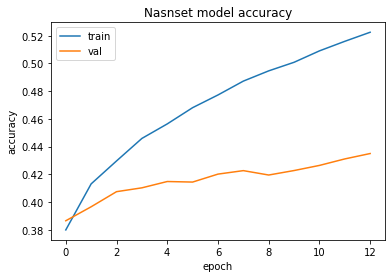

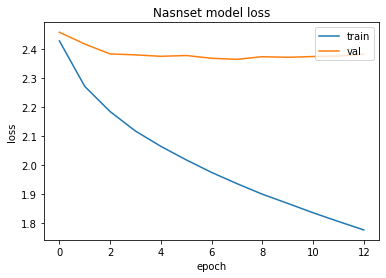

In [131]:
# plot results
plot_results(tuned_model_nasnet_history, 'Nasnset ')

### Accuracy


In [48]:
# evaluate on test data
nasnet_results = tuned_model_nasnet.evaluate(nasnet_test)
print('Test set accuracy nasnet {:.2f}%'.format(nasnet_results[1]*100)) 

790/790 [==============================] - 94s 118ms/step - loss: 2.1009 - accuracy: 0.4525
Test set accuracy nasnet 45.25%


### Make predictions

In [49]:
# compare real to predicted results
nasnet_predictions = np.argmax(tuned_model_nasnet.predict(nasnet_test), axis = 1) 

### Confusion matrix

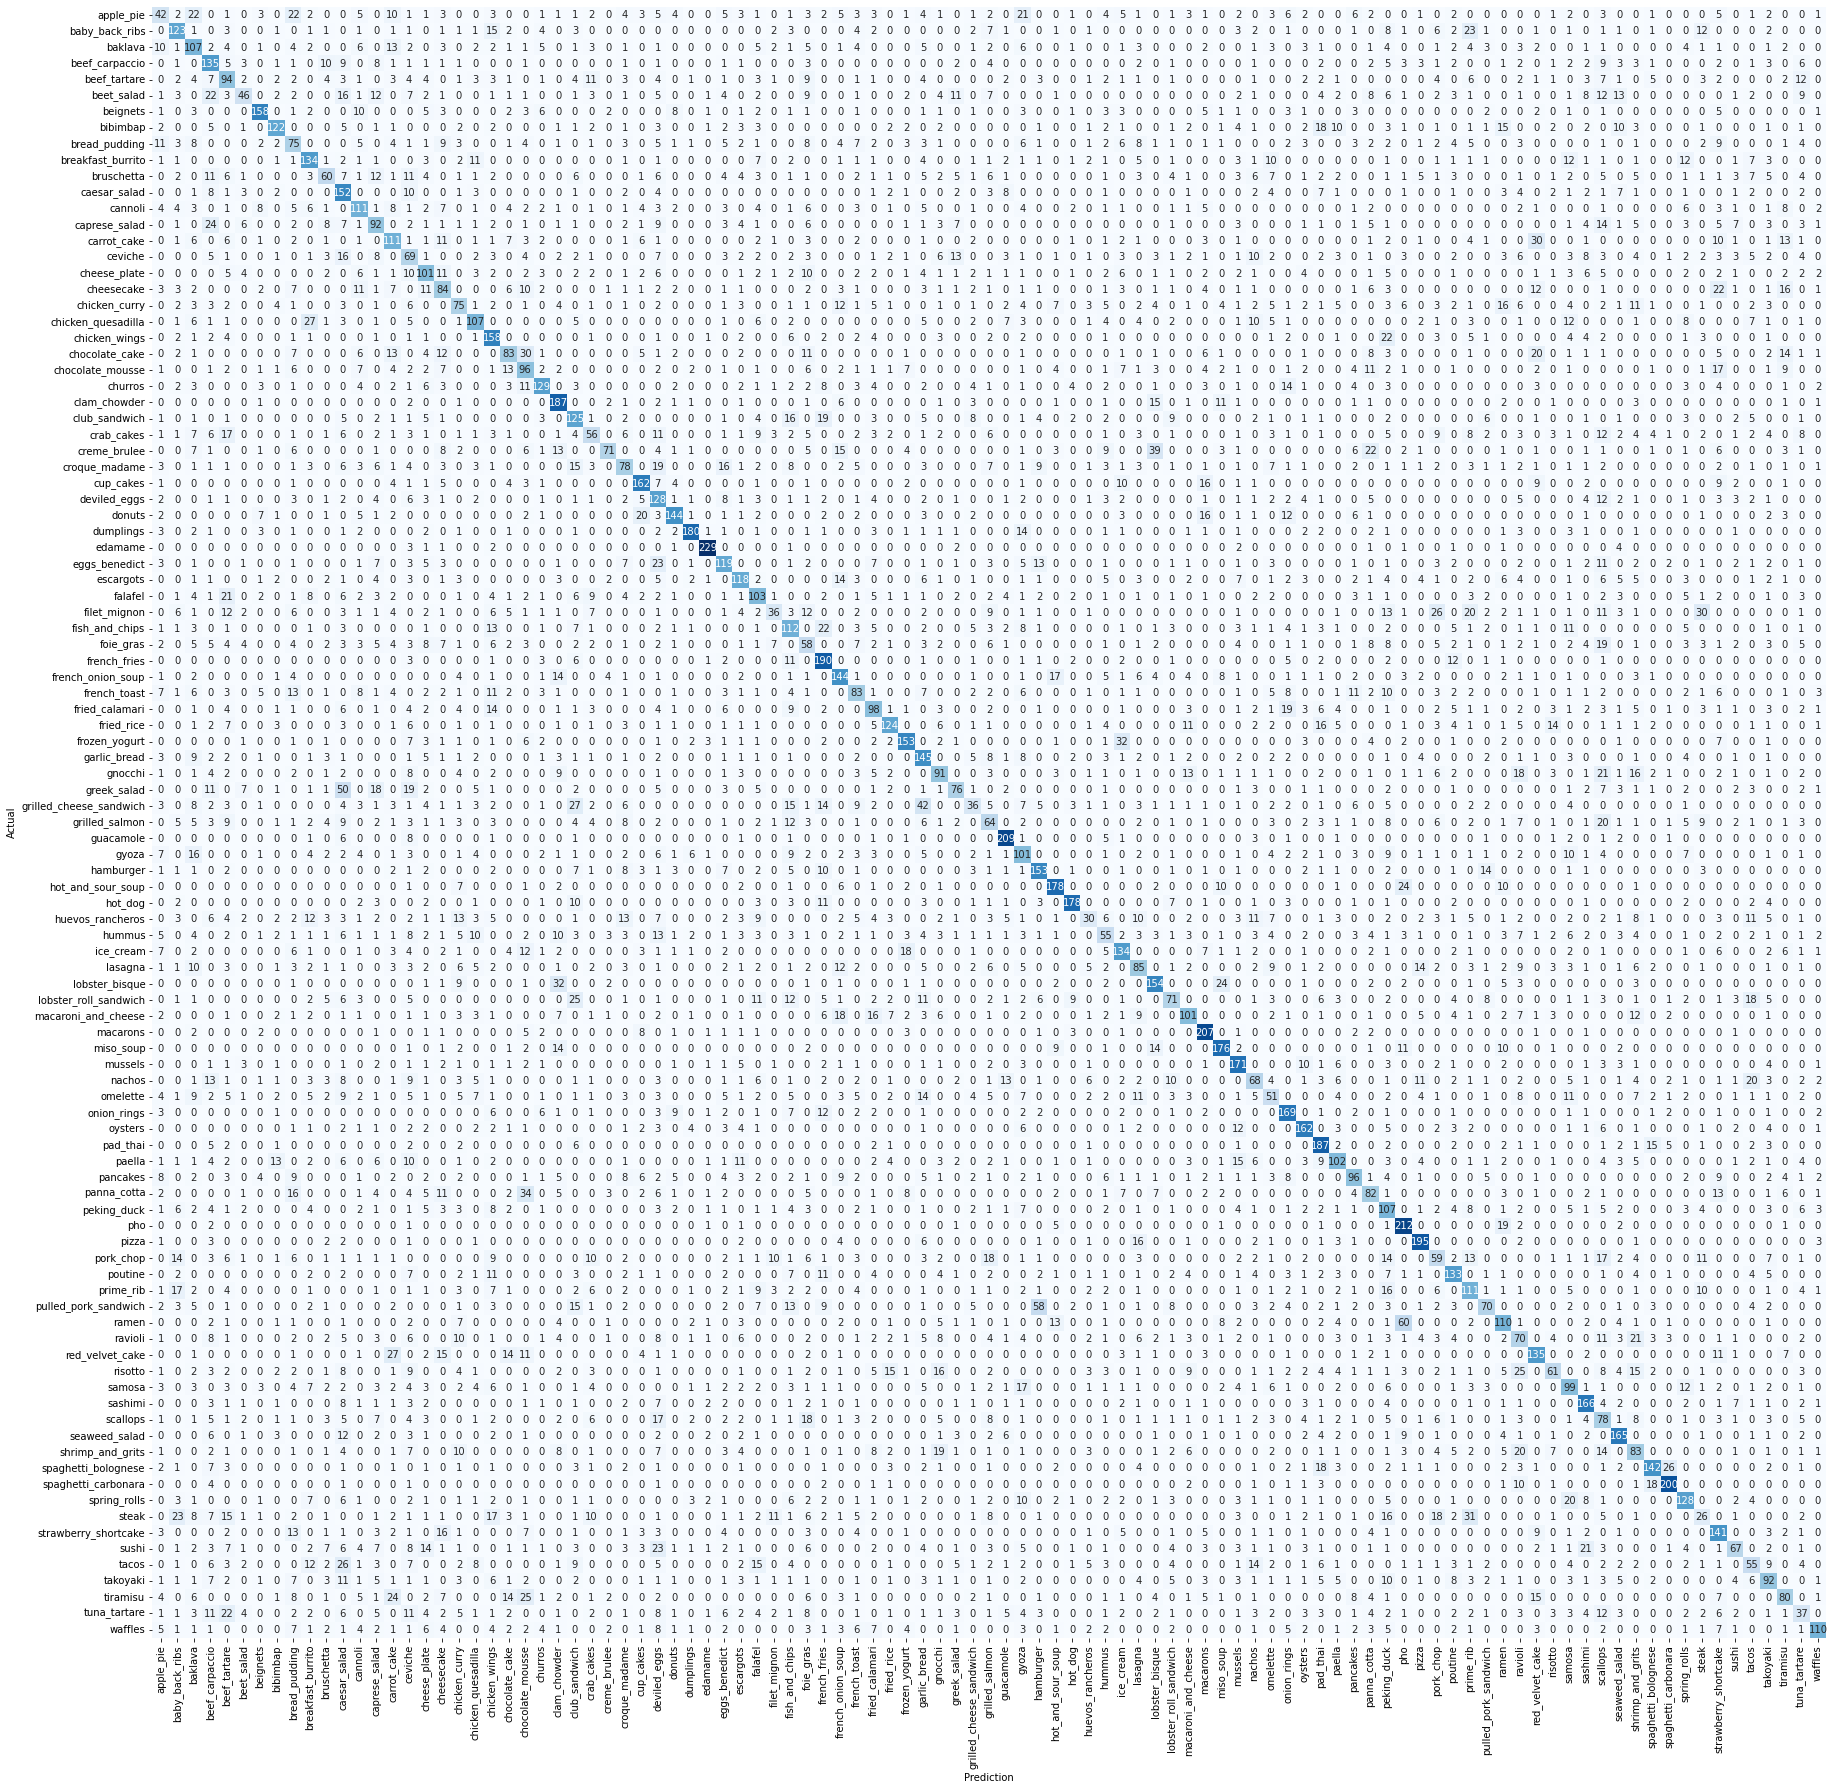

In [50]:
nasnet_conf_matrix = confusion_matrix(nasnet_test.labels,nasnet_predictions)

# create heatmap

plt.figure(figsize = (30,30))
sns.heatmap(nasnet_conf_matrix, vmin=0, annot = True, fmt = 'g', cmap = 'Blues', cbar = False)
plt.xticks(ticks = np.arange(101)+0.5, labels=nasnet_test.class_indices, rotation = 90)
plt.yticks(ticks = np.arange(101)+0.5, labels=nasnet_test.class_indices, rotation = 0)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

### Classification report - additional statistics

In [51]:
# generate report using sklearn
nasnet_report = classification_report(nasnet_test.labels, nasnet_predictions, target_names=nasnet_test.class_indices)


In [53]:
# convert report to dataframe
nasnet_clr_df = classification_report_df(nasnet_report)

In [54]:
# top 10 by F1 score
nasnet_best_f1 = nasnet_clr_df.sort_values(['f1_score'],ascending = False).reset_index(drop=True).head(10)

In [55]:
# bottom 10 by F1 score
nasnet_worst_f1 = nasnet_clr_df.sort_values(['f1_score'],ascending = True).reset_index(drop=True).head(10)
#nasnet_worst_f1

label  precision  recall  f1_score  support
0                    steak       0.18    0.10      0.13    250.0
1         huevos_rancheros       0.35    0.12      0.18    250.0
2             tuna_tartare       0.22    0.15      0.18    250.0
3                apple_pie       0.23    0.17      0.20    250.0
4  grilled_cheese_sandwich       0.30    0.14      0.20    250.0
5             filet_mignon       0.42    0.14      0.21    250.0
6                foie_gras       0.22    0.23      0.22    250.0
7                  ceviche       0.19    0.28      0.22    250.0
8                 omelette       0.27    0.20      0.23    250.0
9                 scallops       0.20    0.31      0.24    250.0

### Dataframe of worst categories by f1_score

In [56]:
# combine worst categories by F1 score for each model into one dataframe

f1_cols = [inception_worst_f1["label"], mobilenet_worst_f1["label"],nasnet_worst_f1["label"]]
headings = ["inception", "mobilenet","nasnet"]

worst_df = pd.concat(f1_cols, axis=1, keys=headings).reset_index(drop=True)
worst_df

inception          mobilenet                   nasnet
0             tuna_tartare       filet_mignon                    steak
1                pork_chop       tuna_tartare         huevos_rancheros
2                apple_pie         crab_cakes             tuna_tartare
3                  ceviche              steak                apple_pie
4  grilled_cheese_sandwich      bread_pudding  grilled_cheese_sandwich
5               cheesecake   huevos_rancheros             filet_mignon
6         huevos_rancheros          pork_chop                foie_gras
7             filet_mignon          apple_pie                  ceviche
8                  falafel            ravioli                 omelette
9            bread_pudding          foie_gras                 scallops

In [86]:
# see which categories occur in all 3 columns
list(set(worst_df.inception) & set(worst_df.mobilenet) & set(worst_df.nasnet))

['     tuna_tartare', ' huevos_rancheros', '  apple_pie', '     filet_mignon']

### Dataframe of best categories by f1_score

In [57]:
# combine best categories by F1 score for each model into one dataframe
f1_cols = [inception_best_f1["label"], mobilenet_best_f1["label"],nasnet_best_f1["label"]]
headings = ["inception", "mobilenet","nasnet"]

best_df = pd.concat(f1_cols, axis=1, keys=headings).reset_index(drop=True)
best_df

inception                mobilenet                   nasnet
0                  hot_dog                  edamame                  edamame
1                  edamame                dumplings      spaghetti_carbonara
2                guacamole                guacamole                guacamole
3      spaghetti_carbonara                 macarons                dumplings
4             french_fries                    pizza                  hot_dog
5                dumplings      spaghetti_carbonara                    pizza
6                    pizza                  oysters                 macarons
7                hamburger                      pho        hot_and_sour_soup
8                cup_cakes            seaweed_salad                miso_soup
9                  waffles        hot_and_sour_soup                      pho

In [85]:
# see which categories occur in all 3 columns
list(set(best_df.inception) & set(best_df.mobilenet	) & set(best_df.nasnet))

['    edamame',
 '    spaghetti_carbonara',
 '  dumplings',
 'pizza',
 '  guacamole']

## Overall Accuracies

In [58]:
print('Test set accuracy inception {:.2f}%'.format(inception_results[1]*100))  
print('Test set accuracy mobilenet {:.2f}%'.format(mobilenet_results[1]*100))  
print('Test set accuracy nasnet    {:.2f}%'.format(nasnet_results[1]*100)) 

Test set accuracy inception 30.98%
Test set accuracy mobilenet 48.60%
Test set accuracy nasnet    45.25%


## Overall macro averages

#### F1 score

In [59]:
# macro average reported as all classes have the same number of images and there is no class imbalance

inception_f1 = f1_score(inception_test.labels, inception_predictions,average='macro')
mobilenet_f1 = f1_score(mobilenet_test.labels, mobilenet_predictions,average='macro')
nasnet_f1 = f1_score(nasnet_test.labels, nasnet_predictions,average='macro')

In [60]:
print('Test set macro F1 score inception {:.2f}'.format(inception_f1))  
print('Test set macro F1 score mobilenet {:.2f}'.format(mobilenet_f1))  
print('Test set macro F1 score nasnet    {:.2f}'.format(nasnet_f1)) 

Test set macro F1 score inception 0.29
Test set macro F1 score mobilenet 0.48
Test set macro F1 score nasnet    0.45


#### recall

In [139]:
inception_recall = recall_score(inception_test.labels, inception_predictions,average='macro')
mobilenet_recall = recall_score(mobilenet_test.labels, mobilenet_predictions,average='macro')
nasnet_recall = recall_score(nasnet_test.labels, nasnet_predictions,average='macro')

print('Test set macro F1 score inception {:.2f}'.format(inception_recall))  
print('Test set macro F1 score mobilenet {:.2f}'.format(mobilenet_recall))  
print('Test set macro F1 score nasnet    {:.2f}'.format(nasnet_recall)) 

Test set macro F1 score inception 0.31
Test set macro F1 score mobilenet 0.49
Test set macro F1 score nasnet    0.45


#### Precision

In [141]:
inception_precision = precision_score(inception_test.labels, inception_predictions,average='macro')
mobilenet_precision = precision_score(mobilenet_test.labels, mobilenet_predictions,average='macro')
nasnet_precision = precision_score(nasnet_test.labels, nasnet_predictions,average='macro')

print('Test set macro precision score inception {:.2f}'.format(inception_precision))  
print('Test set macro precision score mobilenet {:.2f}'.format(mobilenet_precision))  
print('Test set macro precision score nasnet    {:.2f}'.format(nasnet_precision)) 

Test set macro precision score inception 0.30
Test set macro precision score mobilenet 0.49
Test set macro precision score nasnet    0.46


# mobilenet is the best model

### final plot of all train accuracies

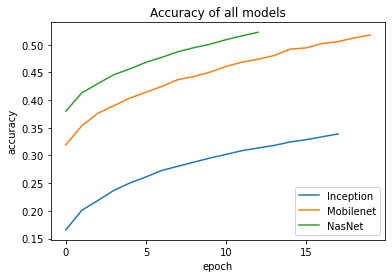

In [125]:
plt.plot(tuned_model_inception_history.history['accuracy'])
plt.plot(tuned_model_mobilenet_history.history['accuracy'])
plt.plot(tuned_model_nasnet_history.history['accuracy'])
plt.title('Accuracy of all models')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Inception', 'Mobilenet', "NasNet"], loc='lower right')
plt.locator_params(axis="both", integer=True, tight=True)
plt.show()

### Final plot of all models val accuracy

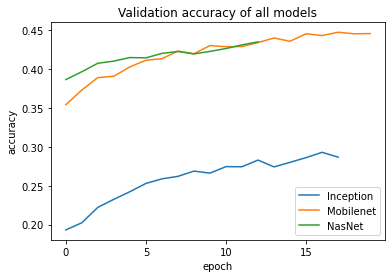

In [124]:
plt.plot(tuned_model_inception_history.history['val_accuracy'])
plt.plot(tuned_model_mobilenet_history.history['val_accuracy'])
plt.plot(tuned_model_nasnet_history.history['val_accuracy'])
plt.title('Validation accuracy of all models')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Inception', 'Mobilenet', "NasNet"], loc='lower right')
plt.locator_params(axis="both", integer=True, tight=True)
plt.show()

### images of misclassified food

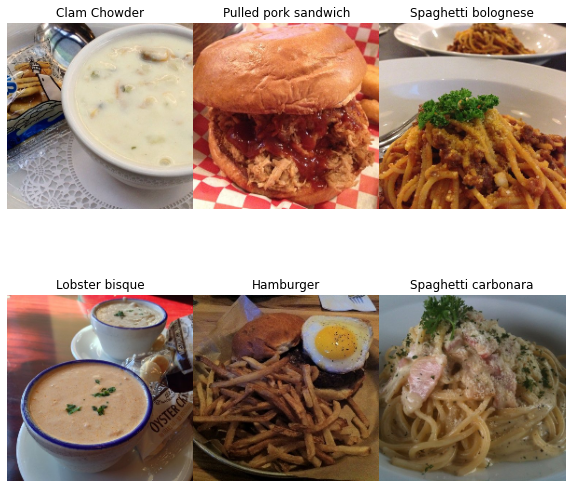

In [198]:
# plot random exmaples 

# create figure
fig=plt.figure(figsize=(10,10))
columns = 3
rows = 2

image_list = []

# set dir to clam chowder
clam_chowder_dir_path = folder_path+'/food-101/images/clam_chowder/'
# get list 
clam_chowder_dir = os.listdir(clam_chowder_dir_path)
# choose random example
clam_choice = random.choice(clam_chowder_dir)
# append to list
image_list.append(clam_chowder_dir_path+clam_choice)

pulled_pork_sandwich_dir_path = folder_path+'/food-101/images/pulled_pork_sandwich/'
pulled_pork_sandwich_dir = os.listdir(pulled_pork_sandwich_dir_path)
pulled_pork_sandwich = random.choice(pulled_pork_sandwich_dir)
image_list.append(pulled_pork_sandwich_dir_path+pulled_pork_sandwich)

spaghetti_bolognese_path = folder_path+'/food-101/images/spaghetti_bolognese/'
spaghetti_bolognese_dir = os.listdir(spaghetti_bolognese_path)
spaghetti_bolognese_choice = random.choice(spaghetti_bolognese_dir)
image_list.append(spaghetti_bolognese_path+spaghetti_bolognese_choice)

lobster_bisque_dir_path = folder_path+'/food-101/images/lobster_bisque/'
lobster_bisque_dir = os.listdir(lobster_bisque_dir_path)
lobster_choice = random.choice(lobster_bisque_dir)
image_list.append(lobster_bisque_dir_path+lobster_choice)

hamburger_dir_path = folder_path+'/food-101/images/hamburger/'
hamburger_dir = os.listdir(hamburger_dir_path)
hamburger_choice = random.choice(hamburger_dir)
image_list.append(hamburger_dir_path+hamburger_choice)

spaghetti_carbonara_path = folder_path+'/food-101/images/spaghetti_carbonara/'
spaghetti_carbonara_dir = os.listdir(spaghetti_carbonara_path)
spaghetti_carbonara_choice = random.choice(spaghetti_carbonara_dir)
image_list.append(spaghetti_carbonara_path+spaghetti_carbonara_choice)

titles = ['Clam Chowder', "Pulled pork sandwich", 'Spaghetti bolognese',"Lobster bisque","Hamburger", 'Spaghetti carbonara']

# Get 4 random steak images
for i in range(6):
    fig.add_subplot(rows, columns, i+1)
    image = plt.imread((image_list[i]))
    image = cv.resize(image, (200, 200))  
    plt.imshow(image) 
    plt.axis('off') # turn off axis
    plt.title(titles[i])
fig.subplots_adjust(wspace=0, hspace=0)    
plt.show()